In [1]:
%pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:

# Load dataset
file_path = "pine_soil_slope_ndvi.csv"  # Update this with the correct path
df = pd.read_csv(file_path)

# Drop non-relevant columns
drop_columns = ["env", "TestId", "Specie", "latitude", "longitude", "date_initial", "date_final", "Feature"]
df = df.drop(columns=drop_columns)

# Handle missing values by filling with the mean
df.fillna(df.mean(), inplace=True)

# Define target and features
y = df["Productivity (y)"]
X = df.drop(columns=["Productivity (y)"])

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Root Mean Squared Error (RMSE): 1.5593


In [4]:
from sklearn.metrics import r2_score

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute R² score
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Root Mean Squared Error (RMSE): 1.5593
R² Score: 0.7984


Include spieces done label encoding 


In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Load dataset
file_path = "pine_soil_slope_ndvi.csv"  # Update with actual file path
df = pd.read_csv(file_path)

# Drop non-relevant columns
drop_columns = ["env", "TestId", "latitude", "longitude", "date_initial", "date_final", "Feature"]
df = df.drop(columns=drop_columns)

# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = ["Specie"]

# Fill missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())  # Fill numeric missing values with mean
df["Specie"] = df["Specie"].fillna(df["Specie"].mode()[0])  # Fill missing species with most frequent value

# Encode the "Specie" column using Label Encoding
label_encoder = LabelEncoder()
df["Specie"] = label_encoder.fit_transform(df["Specie"])

# Define target and features
y = df["Productivity (y)"]
X = df.drop(columns=["Productivity (y)"])

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Root Mean Squared Error (RMSE): 1.1998
R² Score: 0.8807


using correlation analysis

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
file_path = "Data/train_data.csv"  # Update with actual file path
df = pd.read_csv(file_path)

# Drop non-relevant columns
drop_columns = ["env", "TestId", "latitude", "longitude", "date_initial", "date_final", "Feature"]
df = df.drop(columns=drop_columns)

# Fill missing values
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
df["Specie"] = df["Specie"].fillna(df["Specie"].mode()[0])

# Encode the "Specie" column using Label Encoding
label_encoder = LabelEncoder()
df["Specie"] = label_encoder.fit_transform(df["Specie"])

# Compute correlation matrix
corr_matrix = df.corr()

# Select features with a strong correlation to the target variable (threshold = 0.2)
corr_threshold = 0.2
target_corr = corr_matrix["Productivity (y)"].abs().sort_values(ascending=False)
selected_features = target_corr[target_corr > corr_threshold].index.tolist()

# Remove multicollinearity: Drop features highly correlated (> 0.85) with each other
corr_drop_threshold = 0.85
drop_features = set()

for feature in selected_features:
    if feature in drop_features:
        continue
    correlated_features = corr_matrix[feature][corr_matrix[feature].abs() > corr_drop_threshold].index.tolist()
    correlated_features.remove(feature)  # Keep one and drop others
    drop_features.update(correlated_features)

# Final selected features
selected_features = [f for f in selected_features if f not in drop_features]

# Define target and reduced feature set
y = df["Productivity (y)"]
X = df[selected_features].drop(columns=["Productivity (y)"])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Selected Features: {selected_features}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'Data/train_data.csv'

Correlation Matrix:
                          Specie  Productivity (y)  age (years)     bio_1  \
Specie                 1.000000          0.316638          NaN  0.712575   
Productivity (y)       0.316638          1.000000          NaN  0.332676   
age (years)                 NaN               NaN          NaN       NaN   
bio_1                  0.712575          0.332676          NaN  1.000000   
bio_10                 0.591401          0.214494          NaN  0.908505   
bio_11                 0.712385          0.389330          NaN  0.924916   
bio_12                 0.231200          0.333274          NaN  0.163243   
bio_13                 0.391226          0.341539          NaN  0.369758   
bio_14                -0.014249          0.224966          NaN -0.128255   
bio_15                 0.080436         -0.142445          NaN  0.137428   
bio_16                 0.454457          0.335024          NaN  0.431161   
bio_17                 0.006839          0.253063          NaN -0.0

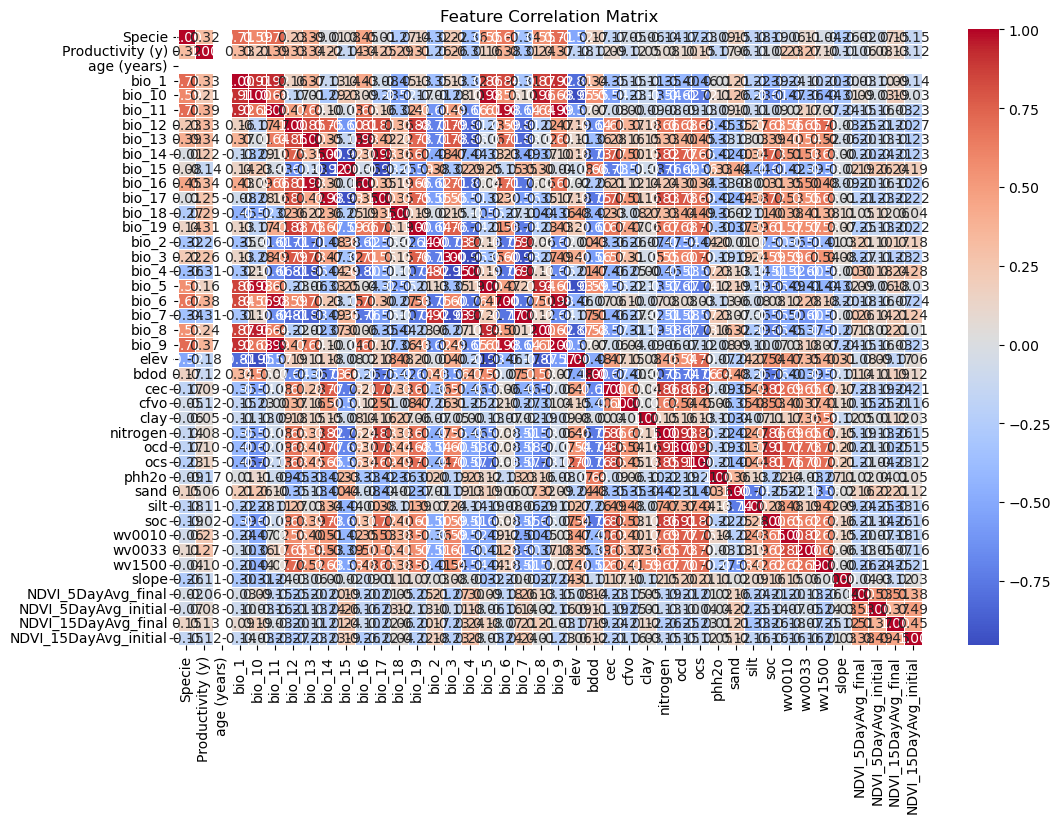

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = "pine_soil_slope_ndvi.csv"  # Update with actual file path
df = pd.read_csv(file_path)

# Drop non-relevant columns
drop_columns = ["env", "TestId", "latitude", "longitude", "date_initial", "date_final", "Feature"]
df = df.drop(columns=drop_columns)

# Fill missing values with mean for numerical columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Encode the "Specie" column using Label Encoding
df["Specie"] = df["Specie"].fillna(df["Specie"].mode()[0])
df["Specie"] = pd.factorize(df["Specie"])[0]

# Compute correlation matrix
corr_matrix = df.corr()

# Print correlation matrix
print("Correlation Matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [2]:
y_corr = corr_matrix["Productivity (y)"].sort_values(ascending=False)

# Print correlation values
print("Correlation with Productivity (y):\n", y_corr)


Correlation with Productivity (y):
 Productivity (y)         1.000000
bio_11                   0.389330
bio_6                    0.384482
bio_9                    0.369021
bio_13                   0.341539
bio_16                   0.335024
bio_12                   0.333274
bio_1                    0.332676
Specie                   0.316638
bio_19                   0.305663
bio_18                   0.285415
wv0033                   0.267205
bio_3                    0.263692
bio_17                   0.253063
bio_8                    0.242694
wv0010                   0.234285
bio_14                   0.224966
bio_10                   0.214494
bio_5                    0.158119
ocs                      0.151670
NDVI_15DayAvg_final      0.127950
ocd                      0.104240
wv1500                   0.101920
cec                      0.094256
nitrogen                 0.080944
NDVI_5DayAvg_initial     0.077684
sand                     0.061253
clay                     0.050380
soc         

In [1]:
import pandas as pd
train_data = pd.read_csv('../../data/train_data.csv')
test_data = pd.read_csv('../../data/test_data.csv')
len(train_data), len(test_data)

(124013, 53149)

In [2]:
# Drop rows with empty values
train_data.drop(["latitude", "longitude", "env", "TestId", "date_initial", "date_final", "Feature", "Unnamed: 0"], axis=1, inplace=True)
test_data.drop(["latitude", "longitude", "env", "TestId", "date_initial", "date_final", "Feature", "Unnamed: 0"], axis=1, inplace=True)

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

len(train_data), len(test_data)


(123981, 53130)

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
num_cols = train_data.select_dtypes(include=["number"]).columns.tolist()
train_data[num_cols] = train_data[num_cols].fillna(train_data[num_cols].mean())
train_data["Specie"] = train_data["Specie"].fillna(train_data["Specie"].mode()[0])

# Encode the "Specie" column using Label Encoding
label_encoder = LabelEncoder()
train_data["Specie"] = label_encoder.fit_transform(train_data["Specie"])

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
num_cols = test_data.select_dtypes(include=["number"]).columns.tolist()
test_data[num_cols] = test_data[num_cols].fillna(test_data[num_cols].mean())
test_data["Specie"] = test_data["Specie"].fillna(test_data["Specie"].mode()[0])

# Encode the "Specie" column using Label Encoding
label_encoder = LabelEncoder()
test_data["Specie"] = label_encoder.fit_transform(test_data["Specie"])

In [6]:
# Compute correlation matrix
corr_matrix = train_data.corr()

# Select features with a strong correlation to the target variable (threshold = 0.2)
corr_threshold = 0.2
target_corr = corr_matrix["Productivity (y)"].abs().sort_values(ascending=False)
selected_features = target_corr[target_corr > corr_threshold].index.tolist()

# Remove multicollinearity: Drop features highly correlated (> 0.85) with each other
corr_drop_threshold = 0.85
drop_features = set()

for feature in selected_features:
    if feature in drop_features:
        continue
    correlated_features = corr_matrix[feature][corr_matrix[feature].abs() > corr_drop_threshold].index.tolist()
    correlated_features.remove(feature)  # Keep one and drop others
    drop_features.update(correlated_features)

# Final selected features
selected_features = [f for f in selected_features if f not in drop_features]

In [10]:
X_train = train_data[selected_features].drop(columns=["Productivity (y)"])
y_train = train_data["Productivity (y)"]

X_test = test_data[selected_features].drop(columns=["Productivity (y)"])
y_test = test_data["Productivity (y)"]

In [11]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Selected Features: {selected_features}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Selected Features: ['Productivity (y)', 'bio_11', 'bio_13', 'bio_7', 'bio_19', 'bio_18', 'Specie', 'wv0033', 'bio_17', 'bio_8', 'wv0010']
Root Mean Squared Error (RMSE): 1.1676
R² Score: 0.8874


In [12]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
reg = TabNetRegressor()
reg.fit(
  X_train.values.astype(float), y_train.values.astype(float).reshape(-1, 1),
  max_epochs=10

)

/opt/anaconda3/envs/tiles/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/opt/anaconda3/envs/tiles/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/anaconda3/envs/tiles/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 12.35966|  0:00:01s
epoch 1  | loss: 3.1606  |  0:00:04s
epoch 2  | loss: 2.71066 |  0:00:07s
epoch 3  | loss: 2.6328  |  0:00:09s
epoch 4  | loss: 2.52261 |  0:00:10s
epoch 5  | loss: 2.37153 |  0:00:12s
epoch 6  | loss: 2.33483 |  0:00:14s
epoch 7  | loss: 2.27122 |  0:00:16s
epoch 8  | loss: 2.25715 |  0:00:19s
epoch 9  | loss: 2.17209 |  0:00:20s


In [13]:
y_pred = reg.predict(X_test.values.astype(float))

# Regression Analysis
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 1.0403
Mean Squared Error (MSE): 1.9830
Root Mean Squared Error (RMSE): 1.4082
R² Score: 0.8362
